In [52]:
import csv
import pandas as pd
import numpy as np
import scipy.signal as ss
import matplotlib
import matplotlib.pyplot as plt
import math
from hrvanalysis import get_time_domain_features, get_frequency_domain_features, get_poincare_plot_features,plot_poincare, get_sampen
from scipy.fftpack import fft
from scipy import stats
from pylab import *
from spectrum import *

In [4]:
ecg = pd.read_csv("E:/ecg-test.csv", sep=';')
#ecg = pd.read_csv("E:/3141595.csv", sep=',')
ecg

,ms,heartrate
0,0,504
1,2,504
2,4,504
3,6,504
4,8,506
5,10,508
6,12,507
7,14,508
8,16,508
9,18,509


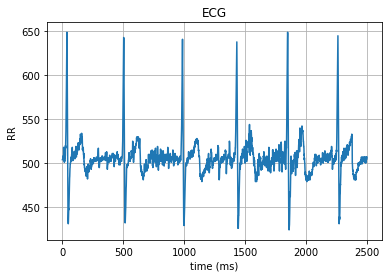

In [3]:
#from hrvanalysis import plot_timeseries

#plot_timeseries(ecg['heartrate'])

# Data for plotting
t = np.arange(0.0, 2.0, 0.01)
#s = 1 + np.sin(2 * np.pi * t)

fig, ax = plt.subplots()
ax.plot(ecg['heartrate'])

ax.set(xlabel='time (ms)', ylabel='RR',
       title='ECG')
ax.grid()

#fig.savefig("test.png")
plt.show()

In [4]:
#ecg = [1000, 1050, 1020, 1080, 1100, 1110, 1060]
tda = get_time_domain_features(ecg['heartrate'])
tda

{'mean_nni': 505.6076,
 'sdnn': 22.51105331272842,
 'sdsd': 5.434354740353391,
 'nni_50': 0,
 'pnni_50': 0.0,
 'nni_20': 42,
 'pnni_20': 1.68,
 'rmssd': 5.434354872949876,
 'median_nni': 505.0,
 'range_nni': 225,
 'cvsd': 0.010748166904433153,
 'cvnni': 0.044522774801503025,
 'mean_hr': 118.89011894111104,
 'max_hr': 141.50943396226415,
 'min_hr': 92.44992295839754,
 'std_hr': 5.017820238455325}

In [32]:
n = len (ecg['heartrate'])
fft_hr = np.fft.fft(ecg['heartrate'])/n
fft_hr = fft_hr [range(n//2)]

In [36]:
fda = get_frequency_domain_features(hr)
fda

{'lf': 628970.3509574077,
 'hf': 118041.47500073032,
 'lf_hf_ratio': 5.328384374674378,
 'lfnu': 84.19817854297995,
 'hfnu': 15.801821457020049,
 'total_power': 3907253.114809929,
 'vlf': 3160241.288851791}

In [17]:
poincare = get_poincare_plot_features(ecg['heartrate'])
poincare

{'sd1': 3.8434381604530166,
 'sd2': 31.602579413772162,
 'ratio_sd2_sd1': 8.222476359564283}

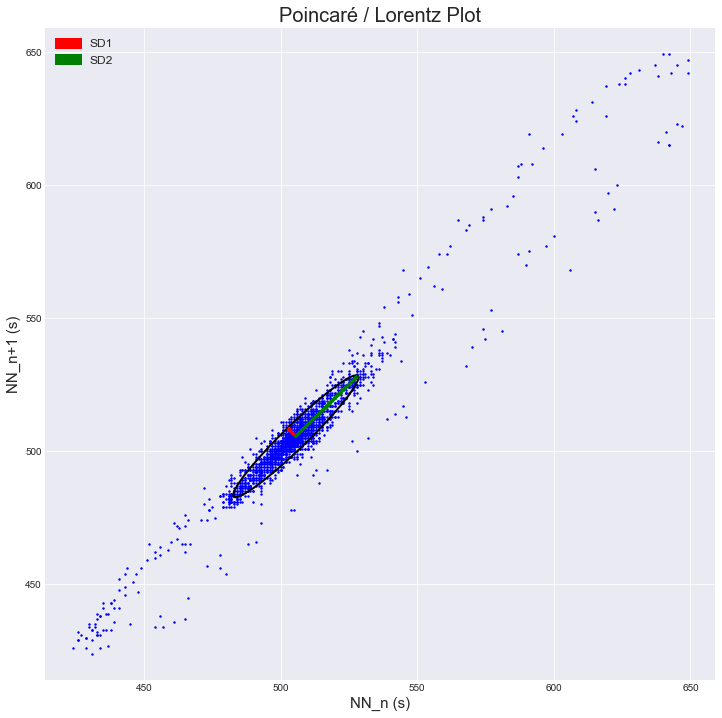

In [18]:
plot_poincare(ecg['heartrate'], plot_sd_features=True)

In [10]:
def SampEn(U, m, r):
    """
    Sample entropy (SampEn) is a modification of approximate entropy (ApEn), 
    used for assessing the complexity of physiological time-series signals
    The value of m represents the length of compared run of data
    r specifies a filtering level
    """
    # get the max distribution
    def _maxdist(x_i, x_j):
        result = max([abs(ua - va) for ua, va in zip(x_i, x_j)])
        return result
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = 1.*np.array([len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))])
        return sum(C)
    N = len(U)
    #SampEn - log A / B
    return -np.log(_phi(m+1) / _phi(m))

In [11]:
SampEn(ecg['heartrate'],2,3)

0.5436570838223164

In [12]:
get_sampen(ecg['heartrate'])

{'sampen': 0.40679627094718374}

In [4]:
# detrended fluctuation analysis

def calc_rms(x, scale):
    """
    windowed Root Mean Square (RMS) with linear detrending.
    """
    # array with data divided in windows
    shape = (x.shape[0]//scale, scale)
    X = np.lib.stride_tricks.as_strided(x,shape=shape)
    # vector of x-axis points to regression
    scale_ax = np.arange(scale)
    rms = np.zeros(X.shape[0])
    for e, xcut in enumerate(X):
        coeff = np.polyfit(scale_ax, xcut, 1)
        xfit = np.polyval(coeff, scale_ax)
        # detrending and computing RMS of each window
        rms[e] = np.sqrt(np.mean((xcut-xfit)**2))
    return rms

def dfa(x, scale_lim=[5,9], scale_dens=0.25, show=False):
    """
    Detrended Fluctuation Analysis - measures power law scaling coefficient
    of the given signal *x*.
    """
    # cumulative sum of data with substracted offset
    y = np.cumsum(x - np.mean(x))
    scales = (2**np.arange(scale_lim[0], scale_lim[1], scale_dens)).astype(np.int)
    fluct = np.zeros(len(scales))
    # computing RMS for each window
    for e, sc in enumerate(scales):
        fluct[e] = np.mean(np.sqrt(calc_rms(y, sc)**2))
    # fitting a line to rms data
    coeff = np.polyfit(np.log2(scales), np.log2(fluct), 1)
    return scales, fluct, coeff[0]

x = ecg['heartrate']
# using hilbert transform
x = np.abs(ss.hilbert(x))
scales, fluct, alpha = dfa(x, show=1)
print(scales)
print(fluct)
print("DFA exponent: {}".format(alpha))

[ 32  38  45  53  64  76  90 107 128 152 181 215 256 304 362 430]
[ 40.1643528   47.51890464  59.19815654  71.93860051  94.2042542
 115.27046419 135.2480514  160.08077922 189.77397376 197.65550083
 223.53324953 233.2397571  263.89909051 277.96115633 316.79892346
 362.135986  ]
DFA exponent: 0.824486074280867


In [67]:
"""
PUCK Analysis
Parameters :  M = order of SMA, usually set from 8 to 64. M has more effect than k
              k = order of OMA, smaller than M 
"""

def PUCK(data, size_data, k, M):
    N = size_data
    
    # estimate OMA
    p = np.zeros((N+M+1,1))
    
    # define MA constant
    w = np.zeros((k,1))
    
    for n in range (1,k):
        w[n] = np.exp(-0.3*n)
    
    #[ar_coeffs,NoiseVariance,reflect_coeffs] = aryule(data[:,1],k)
    #sum_aryule = sum(ar_coeffs[2:k+1])
    #ar_coeffs = ar_coeffs*-1
    
    for t in range (1,N+M+1):
        for n in range (1,k):
            p[t] = p[t] + (w[n+1]*data[t+n-1,1])
            
    #estimate SMA
    pm = np.zeros((N,1))
    for t in range (1,N):
        for n in range (1,M):
            pm[t]= pm[t]+p[t+n-1,1]
        pm[t] = pm[t]/M
        
    #estimate time different measures
    p = p(M+1 in N+M+1)
    pm = pm
    time = np.zeros((N,1))
    interval = zeros((N,1))
    for t in range (1,N):
        time[t] = p(t+1)-p(t)
    for t in range (1,N):
        interval[t] = p(t)-pm(t)
    
    centroid = [np.mean(time), np.mean(interval)]
    avgdistance = np.mean(np.sqrt(np.power(np.abs(time - centroid(1,1)),2)+np.power(np.abs(interval - centroid (1,2)),2)))
    distance = np.sqrt(np.power(np.bs(time - centroid(1,1)),2) + np.power(np.abs(interval-centroid(1,2)),2))
    weight = 1
    #slope = ((time.*weight')'*interval)/((time.*weight')'*time)
    slope = stats.theilslopes(y, x, 0.90) #theilsen regression
    
    R = corrcoef(time,interval)
    correlation = R(1,2)
    RRpredict = p(N) + correlation*time(N)
    
    x1 = time(1)
    y1 = slope*time(1)
    
    x2 = time
    y2 = slope*time(N)
    slopeAngle = math.degrees(math.atan((y1-y2)/(x2-x1))) #inverse tan in degree
    matrix1 = np.array([[math.degrees(math.cos(slopeAngle)), -math.degrees(math.sin(slopeAngle))],[math.degrees(math.sin(slopeAngle)), math.degrees(math.cos(slopeAngle))]])
    matrix2 = np.array([[np.transpose(time(M+1 in N-1))] , [np.transpose(interval(M+1 in N-1))]])
    rot_matrix = np.matmul(matrix1,matrix2)
    new_interval = rot_matrix[1]
    new_time = rot_matrix[2]
    SSD1 = np.std(new_time)
    SSD2 = np.std(new_interval)
    return SSD1,SSD2
    
data = ecg['heartrate']
size_data = len(data)
M = 8
k = 5
SSD1, SSD2 = PUCK(data, size_data, k, M)
print(SSD1)
print(SSD2)

KeyError: (1, 1)